In [2]:
%load_ext autoreload
%autoreload 2

## Global imports

In [26]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune
import torch.nn.functional as F

import numpy as np


## Datasets and dataloaders

In [209]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 200

#random_seed = 1
#torch.backends.cudnn.enabled = False
#torch.manual_seed(random_seed)

#Load data
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)


## Visualize some data

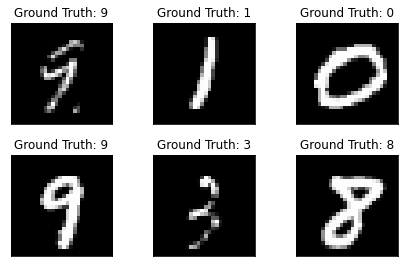

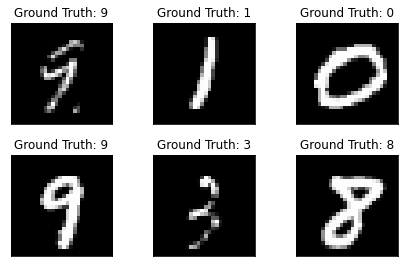

In [13]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Define the model as well as the training/testing loops

In [103]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.yeet = torch.tensor(10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [104]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './pruning_examples/model.pth')
      torch.save(optimizer.state_dict(), './pruning_examples/optimizer.pth')
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

## Try training the model on MNIST

In [22]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 2.3039, Accuracy: 993/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313823
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.296942
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.292989
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.295005
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.312058
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.269324
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.274275
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.189000
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.183399
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.248879
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.135687
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.101465
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.994899
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.893507
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.878418
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.905863
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.683805
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.500590
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.482577
Train Epoch: 1 [12160/

# Experiment with iterative pruning with resetting
From The Lottery Ticket Hypothesis (Strategy 1)
1. Init network

2. Train for *j* epochs

3. Prune *prune_proportion*% of the params, **keep the masks**
4. Load the original network (with freshly initialized params), apply the pruning masks.
5. Repeat steps 2-4 unitl done.

## Each module can store its own mask. After training for a while, we generate a new

In [189]:
def prune_network(model, proportion):
    for module in list(model.children()):
        if isinstance(module,nn.Conv2d) or isinstance(module, nn.Conv1d):
            # conv layer? -> Structured pruning of channels? or unstructured?
            # Below is prune based on l2 norm, by channel
            prune.ln_structured(module, name="weight", amount=proportion, n=2, dim=0)
            # For just unstructured pruning, uncomment the line below:
            #prune.l1_unstructured(module, "weight", proportion)
        elif isinstance(module,nn.Linear):
            # fc layer? -> prune all weights, unstructured
            prune.l1_unstructured(module, "weight", proportion)


In [210]:
repetitions = 3
j_epochs = 2
prune_proportion = 0.1

network = Net()
#init the masks, etc. 
prune_network(network, 0.0)
initial_state_dict = network.state_dict()
# delete all the masks so that they are not loaded later
for k in initial_state_dict.copy():
    if "mask" in k:
        del initial_state_dict[k]


#torch.save(network.state_dict(), './pruning_examples/model.pth') # save the initial model + weights to the disk but also keep in memory

optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

for rep in range(repetitions):
    #load the original weights w/o changing the pruning mask
    network.load_state_dict(initial_state_dict, strict=False)
    print("---------------------\nPRUNING ITERATION ",rep)
    test()
    # train for J iterations
    for epoch in range(j_epochs):
        train(epoch)
    print("J epochs complete...")
    test()
    # prune network
    if rep < repetitions-1: # if not the end of last round
        print("pruning network...")
        prune_network(network, prune_proportion)

torch.save(network.state_dict(), './pruning_examples/model.pth')

    


---------------------
PRUNING ITERATION  0

Test set: Avg. loss: 2.2965, Accuracy: 1378/10000 (14%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.344056
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.076988
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.578307
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.499181
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.518406
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.518226
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.713391
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.516997
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.344579
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.325376
J epochs complete...

Test set: Avg. loss: 0.1256, Accuracy: 9597/10000 (96%)

pruning network...
---------------------
PRUNING ITERATION  1

Test set: Avg. loss: 0.1327, Accuracy: 9587/10000 (96%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.522364
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.219412
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.346778
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.498702
Train Epoch: 0 

In [211]:
network.state_dict()['conv1.weight_mask']

tensor([[[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]],


        [[[0., 0

In [197]:
network.load_state_dict({ k+"_orig":v for k, v in initial_state_dict.items()}, strict = False)

_IncompatibleKeys(missing_keys=['conv1.bias', 'conv1.weight_mask', 'conv2.bias', 'conv2.weight_mask', 'fc1.bias', 'fc1.weight_mask', 'fc2.bias', 'fc2.weight_mask'], unexpected_keys=['conv1.bias_orig', 'conv2.bias_orig', 'fc1.bias_orig', 'fc2.bias_orig'])

In [110]:
for module in list(network.children()):
    if hasattr(module,"name"):
        print(module.name)

In [111]:
def load_my_state_dict(model, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            model eval()
            if name not in own_state:
                 continue
            if isinstance(param, Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            own_state[name].copy_(param)

SyntaxError: invalid syntax (<ipython-input-111-256a5ddc71e9>, line 4)

In [130]:
a=prune.L1Unstructured(0.1)

In [138]:
p = a._compute_mask(network.conv1.weight,network.conv1._mask)

AttributeError: 'L1Unstructured' object has no attribute '_compute_mask'

In [174]:
r = prune.l1_unstructured(network.conv1,name="weight",amount=0.99) #consider using structured to zero out whole channels

In [176]:
network.conv1(torch.tensor(np.random.randn(1,1,10,10) ).type(torch.FloatTensor) )

tensor([[[[-0.0810, -0.0810, -0.0810, -0.0810, -0.0810, -0.0810],
          [-0.0810, -0.0810, -0.0810, -0.0810, -0.0810, -0.0810],
          [-0.0810, -0.0810, -0.0810, -0.0810, -0.0810, -0.0810],
          [-0.0810, -0.0810, -0.0810, -0.0810, -0.0810, -0.0810],
          [-0.0810, -0.0810, -0.0810, -0.0810, -0.0810, -0.0810],
          [-0.0810, -0.0810, -0.0810, -0.0810, -0.0810, -0.0810]],

         [[ 0.0485,  0.0485,  0.0485,  0.0485,  0.0485,  0.0485],
          [ 0.0485,  0.0485,  0.0485,  0.0485,  0.0485,  0.0485],
          [ 0.0485,  0.0485,  0.0485,  0.0485,  0.0485,  0.0485],
          [ 0.0485,  0.0485,  0.0485,  0.0485,  0.0485,  0.0485],
          [ 0.0485,  0.0485,  0.0485,  0.0485,  0.0485,  0.0485],
          [ 0.0485,  0.0485,  0.0485,  0.0485,  0.0485,  0.0485]],

         [[ 0.0180,  0.0180,  0.0180,  0.0180,  0.0180,  0.0180],
          [ 0.0180,  0.0180,  0.0180,  0.0180,  0.0180,  0.0180],
          [ 0.0180,  0.0180,  0.0180,  0.0180,  0.0180,  0.0180],
      

AttributeError: 'builtin_function_or_method' object has no attribute 'random'

In [133]:
network.conv1.__dict__

{'training': True,
 '_parameters': OrderedDict([('weight', Parameter containing:
               tensor([[[[-0.0450, -0.0764,  0.0484,  0.0146,  0.1014],
                         [-0.1503, -0.0612, -0.1415, -0.1924, -0.1455],
                         [-0.0854, -0.1002,  0.0464, -0.1555, -0.1268],
                         [ 0.0801,  0.0166, -0.1553,  0.1781, -0.1834],
                         [-0.0340, -0.1303, -0.1406, -0.1280, -0.0984]]],
               
               
                       [[[ 0.0553,  0.1664,  0.1099,  0.1988, -0.1808],
                         [-0.1877,  0.0880,  0.1807,  0.1151, -0.1891],
                         [-0.0835, -0.1609,  0.1804, -0.1851, -0.1296],
                         [-0.0034,  0.1304, -0.1836,  0.1627,  0.0017],
                         [ 0.1482, -0.1923, -0.0795, -0.0465,  0.0704]]],
               
               
                       [[[-0.0511, -0.0182,  0.0117,  0.0465, -0.0778],
                         [-0.0158, -0.0619, -0.1096, -0.066

In [95]:
initial_state_dict.keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'conv1._mask', 'conv2._mask', 'fc1._mask', 'fc2._mask'])

In [105]:
a = Net()

In [107]:
a.state_dict().keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])